# 0d - Check and aggregate the different lowess fits

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import ast
import moepy

from help_functions import get_glob_temp_exp

In [2]:

qs = ['0.05', '0.17','0.25', '0.5', '0.75', '0.83','0.95']
col_drops=[ 'fit_to_median', 'avg_over','fit_opt', 'shift_years_2020', 'y', 'add', 'min_0.5_diff', 'min_0.5',
           'min_0.5_diff_above_zero', 'median_absolute_deviation', 'rmse',
           'algorithm_sel', 'temp_ch']

In [7]:
DATE = 'Feb12_2024'
approach = '_via_5yravg'

pd_rgi_stats_w_hugonnet = pd.read_csv(f'../data/3_shift_summary_region_characteristics{DATE}.csv', index_col = [0])
pd_rgi_stats_w_hugonnet = pd_rgi_stats_w_hugonnet.set_index('region')
vol_2020_globally = pd_rgi_stats_w_hugonnet.loc['Globally'][f'regional_volume_m3_2020{approach}']
vol_2020_globally

152767463429916.1

In [8]:
def adapt_pd_r(pd_r):
    pd_r = pd_r.loc[pd_r.y.isna()]
    for c in col_drops:
        try:
            pd_r = pd_r.drop(columns=[c])
        except:
            pass
    pd_r = pd_r.rename(columns={'x':'temp_ch'})
    if reg in rgi_list[:-1]:
        pd_r['region'] = reg[3:]
    return pd_r

In [12]:
pd_r_l = []
pd_r_l_100 = []
pd_r_l_500 = []
pd_r_l_reg_temp = []
rgi_list = [f'RGI{str(i).zfill(2)}' for i in range(1, 20)]
rgi_list.append('global')
for reg in rgi_list: 
    # global mean tmep. change steady state lowess fit 
    pd_r = pd.read_csv(f'lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_5000_{DATE}{reg}_ipcc_ar6_likely_range.csv')
    pd_r_l.append(adapt_pd_r(pd_r))
    
    ### same for after 100 simulation years
    pd_r = pd.read_csv(f'lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_21yr_avg_period_lowess_added_quantiles_added_current12deg_100_{DATE}{reg}_ipcc_ar6_likely_range.csv')
    pd_r_l_100.append(adapt_pd_r(pd_r))

    ### for after 500 simulation years
    ### same for after 100 simulation years
    pd_r = pd.read_csv(f'lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_21yr_avg_period_lowess_added_quantiles_added_current12deg_500_{DATE}{reg}_ipcc_ar6_likely_range.csv')
    pd_r_l_500.append(adapt_pd_r(pd_r))
    
    ### regional temp. change steady state lowess fit
    pd_r = pd.read_csv(f'lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_reg_glacier_temp_ch_5000_{DATE}{reg}_ipcc_ar6_likely_range.csv')
    pd_r_l_reg_temp.append(adapt_pd_r(pd_r))

In [13]:
# in the raw files, the global uncertainties are not computed correctly 
# (as we here did the fit over the medians of the individual RGI regions)
# we will get the global uncertainties by aggregating the quantiles from the five 
# larger regions with the same glacier models to aggregate the uncertainties,
# we aggregate the quantiles over five larger regions
list_aggregates = ['only_reg_w_global_models','only_reg_w_global_glogemflow3d',
                   'only_reg_w_global_glogemflow3d_kraaijenbrink', 
                   '06', '11']
pd_global_complex_agg_global = pd.DataFrame(index=np.arange(-0.1,6.9,0.05).round(2),columns = qs)
pd_global_complex_agg_global.loc[:,qs] = 0
pd_global_complex_agg_global_100 = pd.DataFrame(index=np.arange(-0.1,6.9,0.05).round(2),columns = qs)
pd_global_complex_agg_global_100.loc[:,qs] = 0
pd_global_complex_agg_global_500 = pd.DataFrame(index=np.arange(-0.1,6.9,0.05).round(2),columns = qs)
pd_global_complex_agg_global_500.loc[:,qs] = 0

# March 2025: For the regional warming lowess fits, it does not makes sense to aggregate to global uncertainties as we have to add them up via the composites. The reason ist the the different regional warming ...  
#pd_global_complex_agg_global_reg_temp = pd.DataFrame(index=np.arange(-0.1,6.9,0.05).round(2),columns = ['0.17', '0.5', '0.83'])
#pd_global_complex_agg_global_reg_temp.loc[:,qs] = 0
for agg in list_aggregates:
    if agg in ['06','11']:
        pd_low_agg = pd.read_csv(f'lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_5000_Feb12_2024RGI{agg}_ipcc_ar6_likely_range.csv')
        pd_low_agg_100 = pd.read_csv(f'lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_21yr_avg_period_lowess_added_quantiles_added_current12deg_100_Feb12_2024RGI{agg}_ipcc_ar6_likely_range.csv')
        pd_low_agg_500 = pd.read_csv(f'lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_21yr_avg_period_lowess_added_quantiles_added_current12deg_500_Feb12_2024RGI{agg}_ipcc_ar6_likely_range.csv')
        pd_low_agg_reg_temp = pd.read_csv(f'lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_reg_glacier_temp_ch_5000_Feb12_2024RGI{agg}_ipcc_ar6_likely_range.csv')

        agg_regs = agg
        vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[agg][f'regional_volume_m3_2020{approach}']
        
    else:
        pd_low_agg = pd.read_csv(f'lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_5000_Feb12_2024_{agg}_ipcc_ar6_likely_range.csv')
        pd_low_agg_100 = pd.read_csv(f'lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_21yr_avg_period_lowess_added_quantiles_added_current12deg_100_Feb12_2024_{agg}_ipcc_ar6_likely_range.csv')
        pd_low_agg_500 = pd.read_csv(f'lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_21yr_avg_period_lowess_added_quantiles_added_current12deg_500_Feb12_2024_{agg}_ipcc_ar6_likely_range.csv')
        pd_low_agg_reg_temp = pd.read_csv(f'lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_reg_glacier_temp_ch_5000_Feb12_2024_{agg}_ipcc_ar6_likely_range.csv')

        regs = pd_low_agg.region.unique() # it is a list of one item
        print(regs)
        agg_regs = ast.literal_eval(list(regs)[0])
        vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[agg_regs][f'regional_volume_m3_2020{approach}'].sum()
    # here the values are in % rel. to the regional estimates,
    # but we want them to be in % relative to the global 2020 estimates
    pd_low_agg.loc[pd_low_agg.index,qs] = pd_low_agg[qs].values*vol_2020_reg/vol_2020_globally
    pd_low_agg.index = pd_low_agg.x.round(2)
    pd_low_agg = pd_low_agg.loc[pd_low_agg.y.isna()]
    pd_low_agg = pd_low_agg.loc[np.arange(-0.1,6.9,0.05).round(2)]
    ## same for 100
    pd_low_agg_100.loc[pd_low_agg_100.index,qs] = pd_low_agg_100[qs].values*vol_2020_reg/vol_2020_globally
    pd_low_agg_100.index = pd_low_agg_100.x.round(2)
    pd_low_agg_100 = pd_low_agg_100.loc[pd_low_agg_100.y.isna()]
    pd_low_agg_100 = pd_low_agg_100.loc[np.arange(-0.1,6.9,0.05).round(2)]
    ## same for 500
    pd_low_agg_500.loc[pd_low_agg_500.index,qs] = pd_low_agg_500[qs].values*vol_2020_reg/vol_2020_globally
    pd_low_agg_500.index = pd_low_agg_500.x.round(2)
    pd_low_agg_500 = pd_low_agg_500.loc[pd_low_agg_500.y.isna()]
    pd_low_agg_500 = pd_low_agg_500.loc[np.arange(-0.1,6.9,0.05).round(2)]
    ## same for reg_temp
    pd_low_agg_reg_temp.loc[pd_low_agg_reg_temp.index,['0.17', '0.5', '0.83']] = pd_low_agg_reg_temp[['0.17', '0.5', '0.83']].values*vol_2020_reg/vol_2020_globally
    pd_low_agg_reg_temp.index = pd_low_agg_reg_temp.x.round(2)
    pd_low_agg_reg_temp = pd_low_agg_reg_temp.loc[pd_low_agg_reg_temp.y.isna()]
    pd_low_agg_reg_temp = pd_low_agg_reg_temp.loc[np.arange(-0.1,6.9,0.05).round(2)]
    
    for q in qs:
        pd_global_complex_agg_global.loc[pd_low_agg.index,q] += pd_low_agg[q].values.astype(float) # we have to add up the 5 components
        pd_global_complex_agg_global_100.loc[pd_low_agg_100.index,q] += pd_low_agg_100[q].values.astype(float) # we have to add up the 5 components
        pd_global_complex_agg_global_500.loc[pd_low_agg_500.index,q] += pd_low_agg_500[q].values.astype(float) # we have to add up the 5 components
    #for q in ['0.17', '0.5', '0.83']:
    #    pd_global_complex_agg_global_reg_temp.loc[pd_low_agg_reg_temp.index,q] += pd_low_agg_reg_temp[q].values.astype(float) # we have to add up the 5 components

pd_global_complex_agg_global = pd_global_complex_agg_global.astype(float)
pd_global_complex_agg_global_100 = pd_global_complex_agg_global_100.astype(float)
pd_global_complex_agg_global_500 = pd_global_complex_agg_global_500.astype(float)
#pd_global_complex_agg_global_reg_temp = pd_global_complex_agg_global_reg_temp.astype(float)


["['01', '03', '04', '05', '07', '09', '17', '19']"]
["['02', '08', '10', '12', '16', '18']"]
["['13', '14', '15']"]


In [15]:
# here we are only interested in the uncertainties (not in the median quantile). 
# The median quantile was estimated by taking the medians over the regions, 
# summing them up, and then applying a lowess fit. 
# The fits of the median globally are in pd_fits_all_glac_models_5000
# That means: we now just replace the uncertainties of pd_fits_all_glac_models_5000 for 
# the "All" values with these new aggregated uncertainties:
### steady_state
pd_glob_median = pd_r_l[-1]
assert 'All' == pd_glob_median.region.unique()
pd_glob_median.index = pd_glob_median.temp_ch
pd_glob_median.index = pd_glob_median.index.round(2)

for q in ['0.05', '0.17','0.25', ## '0.5', DO not replace the median!!!
          '0.75', '0.83','0.95']:
    pd_glob_median.loc[pd_global_complex_agg_global.index,q] = pd_global_complex_agg_global[q]
pd_glob_median[qs] = pd_glob_median[qs].astype(float)

### after 100 sim years
pd_glob_median_100 = pd_r_l_100[-1]
assert 'All' == pd_glob_median_100.region.unique()
pd_glob_median_100.index = pd_glob_median_100.temp_ch
pd_glob_median_100.index = pd_glob_median_100.index.round(2)

for q in ['0.05', '0.17','0.25', ## '0.5', DO not replace the median!!!
          '0.75', '0.83','0.95']:
    pd_glob_median_100.loc[pd_global_complex_agg_global_100.index,q] = pd_global_complex_agg_global_100[q]
pd_glob_median_100[qs] = pd_glob_median_100[qs].astype(float)

### after 500 sim years
pd_glob_median_500 = pd_r_l_500[-1]
assert 'All' == pd_glob_median_500.region.unique()
pd_glob_median_500.index = pd_glob_median_500.temp_ch
pd_glob_median_500.index = pd_glob_median_500.index.round(2)

for q in ['0.05', '0.17','0.25', ## '0.5', DO not replace the median!!!
          '0.75', '0.83','0.95']:
    pd_glob_median_500.loc[pd_global_complex_agg_global_500.index,q] = pd_global_complex_agg_global_500[q]
pd_glob_median_500[qs] = pd_glob_median_500[qs].astype(float)

### steady_state fit over reg. glacier temperature change
pd_glob_median_reg_temp = pd_r_l_reg_temp[-1]
assert 'All' == pd_glob_median_reg_temp.region.unique()
pd_glob_median_reg_temp.index = pd_glob_median_reg_temp.temp_ch
pd_glob_median_reg_temp.index = pd_glob_median_reg_temp.index.round(2)

for q in [ '0.17', ## '0.5', DO not replace the median!!!
          '0.83']:
    #pd_glob_median_reg_temp.loc[pd_global_complex_agg_global_reg_temp.index,q] = pd_global_complex_agg_global_reg_temp[q]
    pd_glob_median_reg_temp.loc[:,q] = np.NaN 

pd_glob_median_reg_temp[['0.17', '0.5', '0.83']] = pd_glob_median_reg_temp[['0.17', '0.5', '0.83']].astype(float)

In [16]:
pd_glob_median.loc[[1.2,1.5,2.0,2.7,3.0,4.0],qs].round(1)

,0.05,0.17,0.25,0.5,0.75,0.83,0.95
temp_ch,,,,,,,
1.2,38.0,44.7,48.1,60.9,68.4,85.4,94.0
1.5,30.6,35.8,38.0,52.9,62.9,80.1,87.9
2.0,21.6,24.4,27.7,36.5,51.4,56.7,66.3
2.7,12.2,18.3,19.3,24.4,39.1,46.0,57.8
3.0,10.4,15.1,16.6,22.6,35.3,39.6,52.3
4.0,5.2,7.4,9.4,14.4,24.6,26.3,36.5


new aggregated uncertainties:
- uncertainties are much smaller than the conservative regional sum over the quantiles that is currently given in the main manuscript (and e.g. Extended Data Table 1, Fig. 1, Fig. 2)
- As expected, uncertainties are very similar and only slighly larger than if we just use the global models (and directly estimate uncertainties from the global aggregated estimates of these four global models, see Suppl. Fig. S7)


In [17]:
pd_glob_median_100.loc[[1.2,1.5,2.0,2.7,3.0,4.0],qs].round(1)

,0.05,0.17,0.25,0.5,0.75,0.83,0.95
temp_ch,,,,,,,
1.2,77.4,79.5,80.0,83.8,89.9,90.9,92.3
1.5,70.5,74.2,75.0,80.4,86.8,87.3,89.4
2.0,57.5,63.5,65.5,71.7,78.8,80.1,83.3
2.7,42.3,50.0,53.5,59.8,69.4,71.5,76.0
3.0,36.3,47.4,50.4,55.3,66.4,69.0,75.0
4.0,23.4,34.1,37.8,44.5,57.8,61.4,68.2


In [18]:
pd_glob_median_500.loc[[1.2,1.5,2.0,2.7,3.0,4.0],qs].round(1)

,0.05,0.17,0.25,0.5,0.75,0.83,0.95
temp_ch,,,,,,,
1.2,48.7,54.5,57.0,67.7,78.2,81.5,89.4
1.5,41.8,46.5,48.9,60.2,70.9,74.1,81.9
2.0,31.1,34.6,36.7,48.4,59.7,62.7,70.8
2.7,19.3,22.0,24.2,34.1,46.5,49.3,57.2
3.0,16.0,18.7,21.0,31.5,42.4,45.3,52.8
4.0,8.1,10.9,12.9,20.2,30.4,33.6,40.3


In [19]:
# March 2025: For the regional warming lowess fits, it does not makes sense to aggregate to global uncertainties as we have to add them up via the composites. The reason is the  different regional warming ...  
# regionally, we can not easily calculate global uncertainties
pd_glob_median_reg_temp.loc[[1.2,1.5,2.0,2.7,3.0,4.0],['0.17', '0.5', '0.83']].round(1)#.astype(int)

,0.17,0.5,0.83
temp_ch,,,
1.2,NaN,64.5,NaN
1.5,NaN,61.2,NaN
2.0,NaN,52.7,NaN
2.7,NaN,41.7,NaN
3.0,NaN,38.3,NaN
4.0,NaN,31.1,NaN


In [21]:
### steady state lowess fit w. global mean tmep. changes but only with the four global models (here we can directly use the global fit!)
#pd_r_only_global = pd.read_csv('_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_5000_Feb12_2024_only_global_models_ipcc_ar6_likely_range.csv')
#pd_r_only_reg = pd.read_csv('_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_5000_Feb12_2024_only_global_models_ipcc_ar6_likely_range_wrong_global.csv')
#pd_r_only_global = pd.concat([pd_r_only_global, pd_r_only_reg.loc[pd_r_only_reg.region!='All']])
pd_r_only_global=pd.read_csv('lowess_fits_scripts/_raw_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_5000_Feb12_2024_only_global_models_ipcc_ar6_likely_range.csv')
pd_r_only_global = pd_r_only_global.loc[pd_r_only_global.y.isna()]
for c in col_drops:
    try:
        pd_r_only_global = pd_r_only_global.drop(columns=[c])
    except:
        pass
pd_r_only_global = pd_r_only_global.rename(columns={'x':'temp_ch'})

## just to print it out... 
pd_r_only_global_reg_all = pd_r_only_global.loc[pd_r_only_global.region=='All']
pd_r_only_global_reg_all.index = pd_r_only_global_reg_all.temp_ch.round(2)
pd_r_only_global_reg_all.loc[[1.2,1.5,2.0,2.7,3.0,4.0],['0.17', '0.5', '0.83']].round(1) #.astype(int)

,0.17,0.5,0.83
temp_ch,,,
1.2,44.6,62.2,86.4
1.5,35.4,53.7,79.6
2.0,24.3,39.1,55.8
2.7,18.1,28.7,44.6
3.0,15.0,27.0,37.9
4.0,7.7,18.7,26.5


### Save the aggregated lowess fits in ../data

In [22]:
pd_r_l_reg = pd_r_l[:-1]
pd_r_l_reg.append(pd_glob_median)
# frac is only valid for the median values in case of the region=='All'
pd_fits_all_glac_models_5000 = pd.concat(pd_r_l_reg)
pd_fits_all_glac_models_5000 = pd_fits_all_glac_models_5000.reset_index(drop=True)
pd_fits_all_glac_models_5000.to_csv(f'../data/lowess_fit_rel_2020_101yr_avg_steady_state_{DATE}.csv')

In [24]:
pd_r_l_reg_100 = pd_r_l_100[:-1]
pd_r_l_reg_100.append(pd_glob_median_100)
# frac is only valid for the median values in case of the region=='All'
pd_fits_all_glac_models_100 = pd.concat(pd_r_l_reg_100)
pd_fits_all_glac_models_100 = pd_fits_all_glac_models_100.reset_index(drop=True)
pd_fits_all_glac_models_100.to_csv(f'../data/lowess_fit_rel_2020_21yr_avg_after100yr_{DATE}.csv')

In [25]:
pd_r_l_reg_500 = pd_r_l_500[:-1]
pd_r_l_reg_500.append(pd_glob_median_500)
# frac is only valid for the median values in case of the region=='All'
pd_fits_all_glac_models_500 = pd.concat(pd_r_l_reg_500)
pd_fits_all_glac_models_500 = pd_fits_all_glac_models_500.reset_index(drop=True)
pd_fits_all_glac_models_500.to_csv(f'../data/lowess_fit_rel_2020_21yr_avg_after500yr_{DATE}.csv')

In [20]:
# reg. temp change files
pd_r_l_reg_temp = pd_r_l_reg_temp[:-1] # remove the global part and instead add the NaN global uncertainties
pd_r_l_reg_temp.append(pd_glob_median_reg_temp)
# frac is only valid for the median values in case of the region=='All'
pd_fits_all_glac_models_5000_reg_temp = pd.concat(pd_r_l_reg_temp)
pd_fits_all_glac_models_5000_reg_temp = pd_fits_all_glac_models_5000_reg_temp.reset_index(drop=True)
pd_fits_all_glac_models_5000_reg_temp.to_csv(f'../data/lowess_fit_rel_2020_101yr_avg_steady_state_{DATE}_rel_regional_glacier_temp_ch.csv')

In [36]:
# add only global model files
for reg in ['01', '03', '04', '05', '07', '09', '17', '19']:
    pd_fits_all_glac_models_5000_r = pd_fits_all_glac_models_5000.loc[pd_fits_all_glac_models_5000.region==reg].drop(columns=['0.05','0.25','0.75','0.95'])
    pd_r_only_global=pd.concat([pd_r_only_global,pd_fits_all_glac_models_5000_r])
assert len(pd_r_only_global.region.unique()) == 20
#pd_r_only_global = pd_r_only_global.drop(columns='Unnamed: 0').reset_index(drop=True)
pd_r_only_global.to_csv(f'../data/lowess_fit_rel_2020_101yr_avg_steady_state_{DATE}_only_global_models.csv')

### Same for the per-glacier-model lowess fits

In [62]:
pd_r_per_glac_model = pd.read_csv('per_glac_model_lowess_fits_scripts/_raw_fits/fitted_per_model_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_current12deg_5000_Feb12_2024_ipcc_ar6.csv')
pd_r_per_glac_model = adapt_pd_r(pd_r_per_glac_model)
pd_r_per_glac_model['region'] = pd_r_per_glac_model.region.astype(str)
pd_r_per_glac_model.to_csv(f'../data/lowess_fit_rel_2020_101yr_avg_steady_state_{DATE}_per_glac_model.csv')

In [63]:
pd_r_per_glac_model

,temp_ch,0.5,model_author,frac,region,year,it,N
2,-0.10,88.462133,GLIMB,0.20,All,5000,2,500
3,-0.05,88.021433,GLIMB,0.20,All,5000,2,500
4,0.00,87.525810,GLIMB,0.20,All,5000,2,500
5,0.05,86.936452,GLIMB,0.20,All,5000,2,500
7,0.10,86.235724,GLIMB,0.20,All,5000,2,500
...,...,...,...,...,...,...,...,...
21114,6.65,10.041927,PyGEM-OGGM_v13,0.27,19,5000,2,500
21115,6.70,10.023944,PyGEM-OGGM_v13,0.27,19,5000,2,500
21116,6.75,10.005590,PyGEM-OGGM_v13,0.27,19,5000,2,500
21117,6.80,9.986850,PyGEM-OGGM_v13,0.27,19,5000,2,500


### Some comparison on the different approaches (can be probably removed)

In [8]:
pd_low_normal = pd.read_csv(f'fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_5000_{DATE}_ipcc_ar6.csv')

In [9]:

qs = ['0.05', '0.17','0.25', '0.5', '0.75', '0.83','0.95']

pd_global_complex_agg_new = pd.DataFrame(index=np.arange(-0.1,6.9,0.05).round(2),columns = qs)
pd_global_complex_agg_new.loc[:,qs] = 0
for agg in list_aggregates:
    if agg in ['06','11']:
        pd_low_agg = pd.read_csv(f'fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_5000_Feb12_2024RGI{agg}_ipcc_ar6_likely_range.csv')
        agg_regs = agg
        #pd_low_agg = pd_low_normal.loc[pd_low_normal.region==agg]
        vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[agg][f'regional_volume_m3_2020{approach}']
        # here the values are in % rel. to the regional estimates,
        # but we want them to be in % relative to the global 2020 estimates
    else:
        pd_low_agg = pd.read_csv(f'fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_5000_Feb12_2024_{agg}_ipcc_ar6_likely_range.csv')
        regs = pd_low_agg.region.unique() # it is a list of one item
        print(regs)
        agg_regs = ast.literal_eval(list(regs)[0])
        vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[agg_regs][f'regional_volume_m3_2020{approach}'].sum()

    pd_low_agg.loc[pd_low_agg.index,qs] = pd_low_agg[qs].values*vol_2020_reg/vol_2020_globally


    
    pd_low_agg.index = pd_low_agg.x.round(2)
    pd_low_agg = pd_low_agg.loc[pd_low_agg.y.isna()]
    pd_low_agg = pd_low_agg.loc[np.arange(-0.1,6.9,0.05).round(2)]
    for q in qs:
        pd_global_complex_agg_new.loc[pd_low_agg.index,q] += pd_low_agg[q].values # we have to add up the 5 components
    #print(pd_global_complex_agg_new)

["['01', '03', '04', '05', '07', '09', '17', '19']"]
["['02', '08', '10', '12', '16', '18']"]
["['13', '14', '15']"]


In [11]:
_sel = pd_global_complex_agg_new
pd_global_complex_agg_new = pd_global_complex_agg_new.astype(float)

### CHeck influence of median on how it is aggregated ...

In [18]:
DATE = 'Feb12_2024' 
fill_option = 'repeat_last_101yrs' 
path_merged_runs_scaled_extend = f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)

approach = '_via_5yravg'
ds_reg_yr_shift= xr.open_dataset(f'/data/GMIP3_reg_glacier_model_data/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}{approach}.nc')

/home/users/lschuster/mambaforge/envs/oggm_gmip3/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [34]:

ipcc_ar6 = True
pd_global_temp = get_glob_temp_exp()

In [35]:
# Let's take the median estimate from all glacier models for every RGI region and then do the sum:

from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous, compute_steady_state_yr
hue_order_anonymous = []

pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if (m!='OGGM-VAS') and (m!='OGGM_v153'):
        hue_order.append(m)
        pal_models_l.append(p)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
pal_models = pal_models_l

print(hue_order, hue_order_anonymous)
# select the right models:
ds_reg_models = ds_reg_models.sel(model_author = hue_order)
pal_models = sns.color_palette(pal_models)

dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
    
# select the right models
ds_reg_models = ds_reg_models.sel(model_author=hue_order)
ds_reg_models_vol = ds_reg_models.volume_m3

glac_models = hue_order

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 

ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario']).rolling(simulation_year=101, center=True).mean().dropna(dim='simulation_year', how='all')
ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')

experiments_l = get_glob_temp_exp(region='global').index


['PyGEM-OGGM_v13', 'GloGEMflow', 'GloGEMflow3D', 'OGGM_v16', 'GLIMB', 'Kraaijenbrink', 'GO', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8']


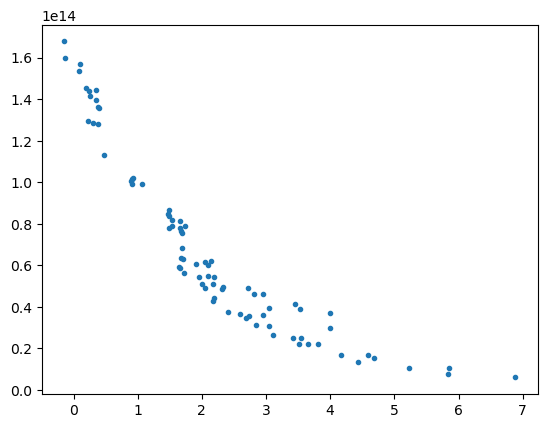

In [36]:
plt.plot( get_glob_temp_exp(region='global')['temp_ch_ipcc'], ds_reg_models_med_vol.isel(simulation_year=-1).sum(dim='rgi_reg').sel(experiments=experiments_l),'.')

In [37]:
ds_reg_models_vol_ss = ds_reg_models_vol.isel(simulation_year=-1)

In [38]:
_sum_l=[]
_sum_0l=[]
for agg in [['06'],['11'], ['01', '03', '04', '05', '07', '09', '17', '19'],
            ['02', '08', '10', '12', '16', '18'],['13', '14', '15']]:
    _sum = ds_reg_models_vol_ss.sel(rgi_reg=agg).dropna(dim='model_author').sum(dim='rgi_reg').median(dim='model_author')
    _sum['reg_agg'] = str(agg)
    _sum_l.append(_sum)
    ###
    _sum_0 = ds_reg_models.volume_m3.isel(simulation_year=0).sel(rgi_reg=agg).dropna(dim='model_author').sum(dim='rgi_reg').median(dim='model_author')
    _sum_0['reg_agg'] = str(agg)
    _sum_0l.append(_sum_0)
    
sum_med_sum = xr.concat(_sum_l, dim='reg_agg').sum(dim='reg_agg')
med_sum = ds_reg_models_vol_ss.median(dim='model_author').sum(dim='rgi_reg')
sum_med_sum0 = xr.concat(_sum_0l, dim='reg_agg').sum(dim='reg_agg')

med_sum0 = ds_reg_models.volume_m3.isel(simulation_year=0).median(dim='model_author').sum(dim='rgi_reg')


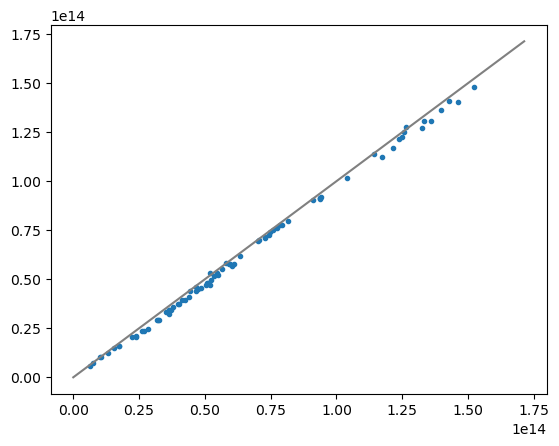

In [39]:
plt.plot(ds_reg_models_vol_ss.sel(rgi_reg=['01', '03', '04', '05', '07', '09', '17', '19']).dropna(dim='model_author').sum(dim='rgi_reg').median(dim='model_author'),
         ds_reg_models_vol_ss.sel(rgi_reg=['01', '03', '04', '05', '07', '09', '17', '19']).dropna(dim='model_author').median(dim='model_author').sum(dim='rgi_reg'),
         '.')
plt.plot([0,sum_med_sum.max()], [0,sum_med_sum.max()], color='grey')


In [40]:
np.testing.assert_allclose(sum_med_sum0/med_sum0,1)

In [41]:
# this here works for the mean .... (but it does not work for the median... )
#np.testing.assert_allclose(sum_med_sum/med_sum,1, rtol=1e-4)

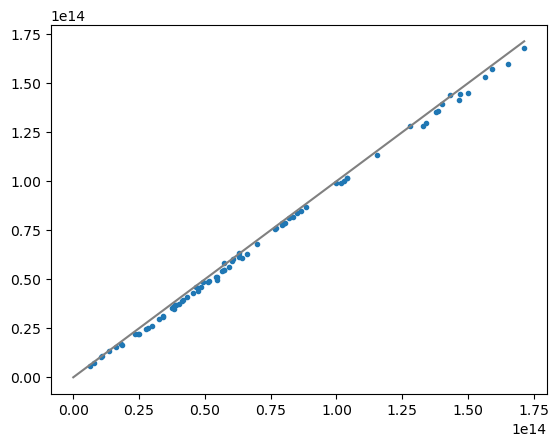

In [42]:
plt.plot(sum_med_sum,med_sum,'.')
plt.plot([0,sum_med_sum.max()], [0,sum_med_sum.max()], color='grey')


In [43]:
pd_sum_med_sum =sum_med_sum.to_dataframe()
pd_med_sum = med_sum.to_dataframe()
pd_sum_med_sum.loc[pd_global_temp.index, 'temp_ch_ipcc'] =  pd_global_temp['temp_ch_ipcc'].values

pd_sum_med_sum.loc[pd_med_sum.index, 'sum_over_reg_medians'] = 100*pd_med_sum['volume_m3'].values/vol_2020_globally
pd_sum_med_sum.loc[pd_med_sum.index, 'sum_over_agg_reg_medians'] = 100*pd_sum_med_sum['volume_m3'].values/vol_2020_globally

In [44]:
pd_sum_med_sum['ratio'] = pd_sum_med_sum.sum_over_agg_reg_medians/pd_sum_med_sum['sum_over_reg_medians']
pd_sum_med_sum['diff'] = pd_sum_med_sum.sum_over_agg_reg_medians - pd_sum_med_sum['sum_over_reg_medians']

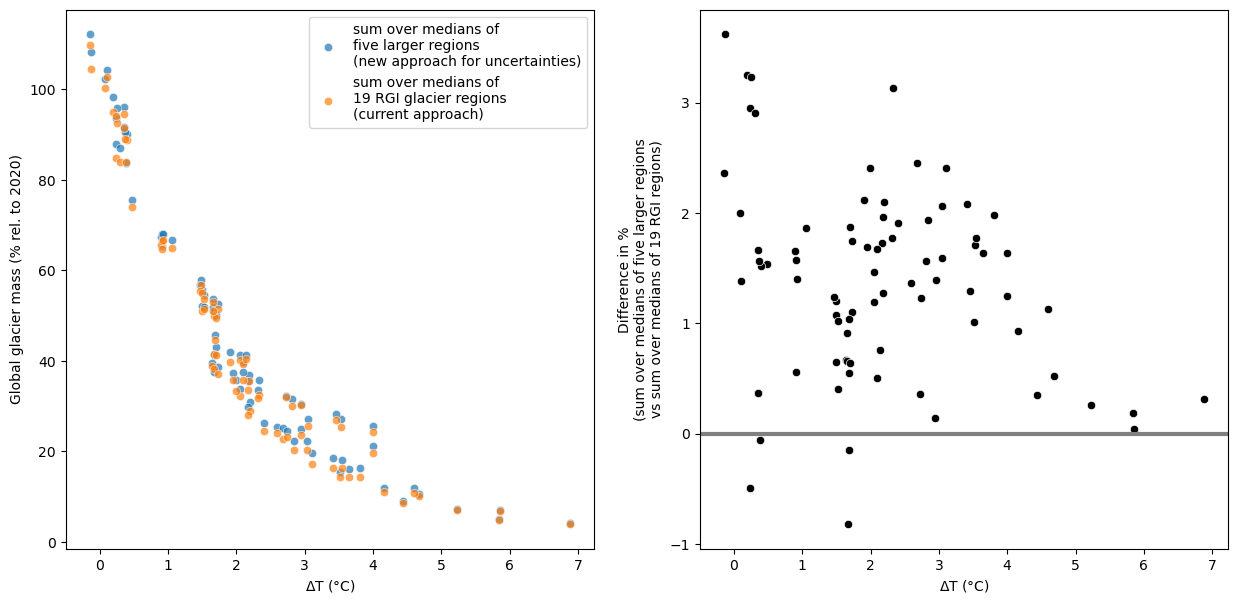

In [45]:
plt.figure(figsize=(15,7))
plt.subplot(121)
sns.scatterplot(data=pd_sum_med_sum, x='temp_ch_ipcc', y='sum_over_agg_reg_medians',
                label='sum over medians of\nfive larger regions\n(new approach for uncertainties)', alpha = 0.7)
sns.scatterplot(data=pd_sum_med_sum, x='temp_ch_ipcc', y='sum_over_reg_medians',
                label ='sum over medians of\n19 RGI glacier regions\n(current approach)', alpha = 0.7)

plt.ylabel('Global glacier mass (% rel. to 2020)')
plt.xlabel(r'$\Delta$T (°C)')
plt.subplot(122)
sns.scatterplot(data=pd_sum_med_sum, x='temp_ch_ipcc', y='diff', color='black')
plt.axhline(0,lw=3, color='grey')
plt.ylabel('Difference in %\n(sum over medians of five larger regions\nvs sum over medians of 19 RGI regions)')
plt.xlabel(r'$\Delta$T (°C)')
plt.savefig('approaches_to_compute_the_median.png')

In [50]:
y

array([ 87.79559  ,  75.59363  ,  90.198975 ,  67.31606  ,  52.131798 ,
        57.899414 ,  51.93683  ,  50.52314  ,  41.33349  ,  36.871334 ,
        52.61757  ,  31.660711 ,  27.22839  ,  45.612827 ,  27.073183 ,
        21.23657  , 108.15851  , 112.14426  ,  86.9002   ,  65.36223  ,
        39.50067  ,  41.254578 ,  37.463593 ,  33.67183  ,  25.400024 ,
        22.33712  ,  30.978495 ,  15.440788 ,  11.942964 ,  29.769627 ,
        10.625323 ,   6.952806 , 102.3264   , 104.16589  ,  96.16344  ,
        68.075424 ,  56.675987 ,  55.542423 ,  54.634827 ,  53.74283  ,
        39.838444 ,  41.20093  ,  50.12051  ,  32.326653 ,  30.41977  ,
        51.81985  ,  28.208038 ,  25.51837  ,  98.24293  ,  95.85801  ,
        83.762276 ,  68.083954 ,  38.72     ,  43.154785 ,  41.901062 ,
        35.765053 ,  26.31411  ,  25.115862 ,  37.48006  ,  19.680897 ,
        18.037195 ,  37.39487  ,  16.373022 ,  12.002929 ,  90.60567  ,
        91.74645  ,  93.57783  ,  66.67959  ,  35.476826 ,  35.6

In [78]:
sel_t.index = sel_t.index.round(2)
sel_t.loc[[1.2,1.5,2.0,2.7,3.0,4.0]]

quantiles,0.5,frac,region,year,it,N,fit_opt,y,min_0.5_diff,min_0.5,min_0.5_diff_above_zero,median_absolute_deviation,rmse,algorithm_sel
x,,,,,,,,,,,,,,
1.2,62.373483,0.14,All,5000,2,500,lowess_fit,NaN,0.0481,4.659843,0.0481,2.514961,4.07416,non_negative_and_decreasing
1.5,52.514136,0.14,All,5000,2,500,lowess_fit,NaN,0.0481,4.659843,0.0481,2.514961,4.07416,non_negative_and_decreasing
2.0,37.960147,0.14,All,5000,2,500,lowess_fit,NaN,0.0481,4.659843,0.0481,2.514961,4.07416,non_negative_and_decreasing
2.7,26.030015,0.14,All,5000,2,500,lowess_fit,NaN,0.0481,4.659843,0.0481,2.514961,4.07416,non_negative_and_decreasing
3.0,24.381455,0.14,All,5000,2,500,lowess_fit,NaN,0.0481,4.659843,0.0481,2.514961,4.07416,non_negative_and_decreasing
4.0,16.399218,0.14,All,5000,2,500,lowess_fit,NaN,0.0481,4.659843,0.0481,2.514961,4.07416,non_negative_and_decreasing


In [86]:
sel_norm_all = pd_low_normal.loc[pd_low_normal.region == 'All']
sel_norm_all = sel_norm_all.loc[sel_norm_all.y.isna()]
sel_norm_all.index = sel_norm_all.x
sel_norm_all.index = sel_norm_all.index.round(2)
sel_norm_all.loc[[1.2,1.5,2.0,2.7,3.0,4.0]]

,x,0.05,0.25,0.5,0.75,0.95,frac,region,year,fit_to_median,...,fit_opt,shift_years_2020,y,add,min_0.5_diff,min_0.5,min_0.5_diff_above_zero,median_absolute_deviation,rmse,algorithm_sel
x,,,,,,,,,,,,,,,,,,,,,
1.2,1.2,52.570248,57.545283,60.289471,60.139074,66.641965,0.23,All,5000,False,...,lowess_fit,True,NaN,NaN,0.087584,4.808715,0.087584,2.613016,4.206593,non_negative_and_decreasing
1.5,1.5,41.779585,49.221156,52.798979,54.120481,61.484724,0.23,All,5000,False,...,lowess_fit,True,NaN,NaN,0.087584,4.808715,0.087584,2.613016,4.206593,non_negative_and_decreasing
2.0,2.0,31.163602,32.289840,36.260625,41.861909,44.642124,0.23,All,5000,False,...,lowess_fit,True,NaN,NaN,0.087584,4.808715,0.087584,2.613016,4.206593,non_negative_and_decreasing
2.7,2.7,19.854313,22.034278,24.439460,29.038282,33.131111,0.23,All,5000,False,...,lowess_fit,True,NaN,NaN,0.087584,4.808715,0.087584,2.613016,4.206593,non_negative_and_decreasing
3.0,3.0,17.168672,19.897759,22.414929,28.163813,31.523450,0.23,All,5000,False,...,lowess_fit,True,NaN,NaN,0.087584,4.808715,0.087584,2.613016,4.206593,non_negative_and_decreasing
4.0,4.0,10.852475,12.460028,14.638504,21.285306,27.332475,0.23,All,5000,False,...,lowess_fit,True,NaN,NaN,0.087584,4.808715,0.087584,2.613016,4.206593,non_negative_and_decreasing


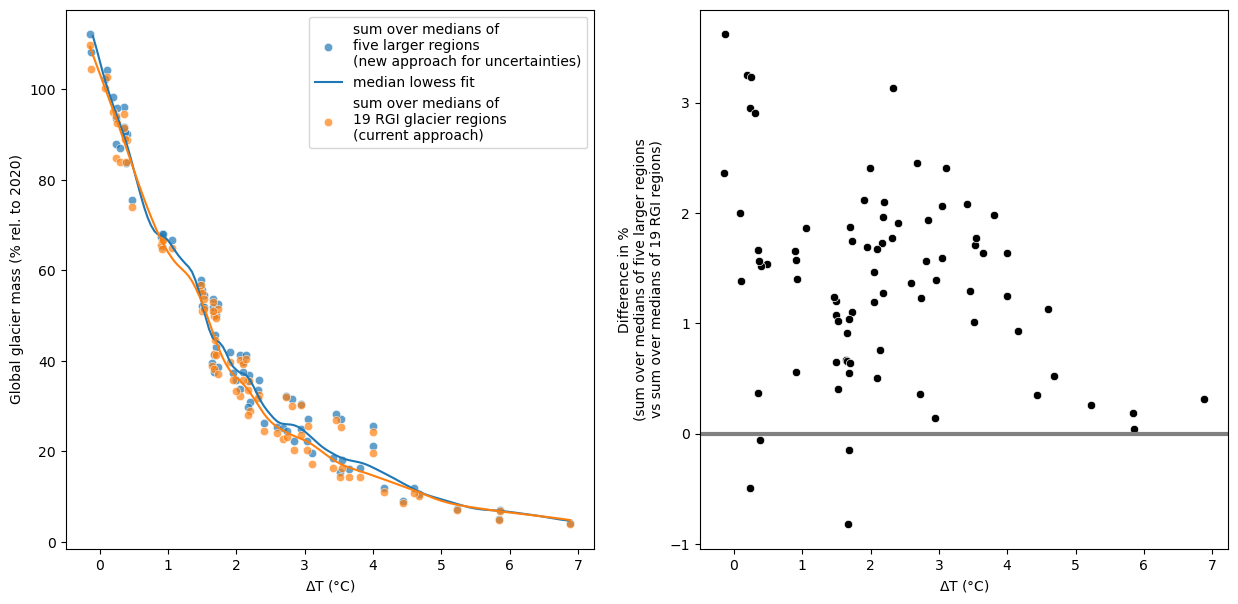

In [84]:
plt.figure(figsize=(15,7))
plt.subplot(121)
sns.scatterplot(data=pd_sum_med_sum, x='temp_ch_ipcc', y='sum_over_agg_reg_medians',
                label='sum over medians of\nfive larger regions\n(new approach for uncertainties)', alpha = 0.7, color='C0')
plt.plot(sel_t.index, sel_t[0.5], color = 'C0', label='median lowess fit' )

sns.scatterplot(data=pd_sum_med_sum, x='temp_ch_ipcc', y='sum_over_reg_medians',
                label ='sum over medians of\n19 RGI glacier regions\n(current approach)', alpha = 0.7, color='C1')
plt.plot(pd_low_normal.loc[pd_low_normal.region == 'All'].x,pd_low_normal.loc[pd_low_normal.region == 'All']['0.5'],
         color = 'C1', label='median lowess fit' )
plt.ylabel('Global glacier mass (% rel. to 2020)')
plt.xlabel(r'$\Delta$T (°C)')
plt.subplot(122)
sns.scatterplot(data=pd_sum_med_sum, x='temp_ch_ipcc', y='diff', color='black')
plt.axhline(0,lw=3, color='grey')
plt.ylabel('Difference in %\n(sum over medians of five larger regions\nvs sum over medians of 19 RGI regions)')
plt.xlabel(r'$\Delta$T (°C)')
plt.savefig('approaches_to_compute_the_median.png')